In [1]:
!pip install torchinfo

In [3]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch import nn
from torch import optim
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import models 
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchinfo import summary 



In [3]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default


In [4]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [5]:
# Create Dataset
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
dataset_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [6]:
# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data Transformer
tfm2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
dataset = ImageFolder(dataset_dir, transform=tfm)
test_ds = ImageFolder(valid_dir, transform=tfm2)

In [8]:
print(dataset.class_to_idx)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [9]:
# Define the percentage of data to use for testing
validation_split = 0.2

# Calculate the length of the test split
vali_length = int(len(dataset) * validation_split)

# Calculate the length of the training split
train_length = len(dataset) - vali_length

# Split the dataset into training and test sets
train_dataset, vali_dataset = random_split(dataset, [train_length, vali_length])

# Length of Train and Test Datasets
LEN_TRAIN = len(train_dataset)
LEN_TEST = len(vali_dataset)
LEN_TEST2 = len(test_ds)

print("len of total (train) dataset {}, len of train {}, len of validation {}".format(len(dataset),len(train_dataset),len(vali_dataset)))
print("len of test dataset {}".format(len(test_ds)))

len of total (train) dataset 70295, len of train 56236, len of validation 14059
len of test dataset 17572


In [10]:
# Create data loaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [11]:
# Model
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


  0%|          | 0.00/21.9M [00:00<?, ?B/s]

In [12]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 38)
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=38, bias=True)
)


In [11]:
summary(model,input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [32, 38]                  38,016
├─PatchEmbed: 1-1                        [32, 196, 192]            --
│    └─Conv2d: 2-1                       [32, 192, 14, 14]         (147,648)
│    └─Identity: 2-2                     [32, 196, 192]            --
├─Dropout: 1-2                           [32, 197, 192]            --
├─Identity: 1-3                          [32, 197, 192]            --
├─Sequential: 1-4                        [32, 197, 192]            --
│    └─Block: 2-3                        [32, 197, 192]            --
│    │    └─LayerNorm: 3-1               [32, 197, 192]            (384)
│    │    └─Attention: 3-2               [32, 197, 192]            (148,224)
│    │    └─Identity: 3-3                [32, 197, 192]            --
│    │    └─Identity: 3-4                [32, 197, 192]            --
│    │    └─LayerNorm: 3-5               [32, 197, 192]         

In [13]:
# Optimiser
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimiser = Adam(model.head.parameters(), lr=0.0001, weight_decay=0.0001)

In [14]:
# lr scheduler
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=3, gamma=0.97)

#  exp_lr_scheduler.step()

In [14]:
# Lists to store the training and validation loss & accuracy for each epoch
train_losses = []
val_losses = []

train_accu = []
val_accu = []

for epoch in range(20):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = criterion(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in vali_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            val_loss = criterion(test_prob, ytest)
            
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    
    train_accu.append(ep_tr_acc)
    val_accu.append(ep_test_acc)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Validation_acc: {ep_test_acc}")

100%|██████████| 1758/1758 [08:13<00:00,  3.56batch/s]


Epoch: 0, Time: 10.223011922836303, Loss: 1.4429641962051392
Train_acc: 0.7332313820328615, Validation_acc: 0.8948716124902197


100%|██████████| 1758/1758 [04:40<00:00,  6.28batch/s]


Epoch: 1, Time: 5.789008335272471, Loss: 1.0921841859817505
Train_acc: 0.8916708158474999, Validation_acc: 0.9267373212888541


100%|██████████| 1758/1758 [04:36<00:00,  6.35batch/s]


Epoch: 2, Time: 5.726457258065541, Loss: 0.9555603861808777
Train_acc: 0.9180418237427982, Validation_acc: 0.9420300163596272


100%|██████████| 1758/1758 [04:34<00:00,  6.41batch/s]


Epoch: 3, Time: 5.683321011066437, Loss: 1.0437906980514526
Train_acc: 0.9305427128529767, Validation_acc: 0.9470090333594139


100%|██████████| 1758/1758 [04:33<00:00,  6.42batch/s]


Epoch: 4, Time: 5.6675709128379825, Loss: 1.021689534187317
Train_acc: 0.939593854470446, Validation_acc: 0.9539796571591151


100%|██████████| 1758/1758 [04:38<00:00,  6.31batch/s]


Epoch: 5, Time: 5.753760858376821, Loss: 1.0372132062911987
Train_acc: 0.9455331104630486, Validation_acc: 0.9549043317447898


100%|██████████| 1758/1758 [04:34<00:00,  6.41batch/s]


Epoch: 6, Time: 5.6734129905700685, Loss: 0.8796847462654114
Train_acc: 0.9491251155843232, Validation_acc: 0.9605946368874031


100%|██████████| 1758/1758 [04:33<00:00,  6.43batch/s]


Epoch: 7, Time: 5.6651617328325905, Loss: 0.8604434132575989
Train_acc: 0.9528238139270219, Validation_acc: 0.9617326979159257


100%|██████████| 1758/1758 [04:34<00:00,  6.40batch/s]


Epoch: 8, Time: 5.69699774980545, Loss: 0.8226745128631592
Train_acc: 0.9562024326054485, Validation_acc: 0.9618038267302084


100%|██████████| 1758/1758 [04:36<00:00,  6.36batch/s]


Epoch: 9, Time: 5.715823845068614, Loss: 0.9153419137001038
Train_acc: 0.9573938402446831, Validation_acc: 0.9652180098157763


100%|██████████| 1758/1758 [04:33<00:00,  6.42batch/s]


Epoch: 10, Time: 5.690083746115366, Loss: 0.7875096797943115
Train_acc: 0.9600078241695711, Validation_acc: 0.9653602674443417


100%|██████████| 1758/1758 [04:31<00:00,  6.47batch/s]


Epoch: 11, Time: 5.6617683410644535, Loss: 0.8583247065544128
Train_acc: 0.9621594708016218, Validation_acc: 0.9677075183156697


100%|██████████| 1758/1758 [04:32<00:00,  6.44batch/s]


Epoch: 12, Time: 5.650006858507792, Loss: 0.9949601292610168
Train_acc: 0.9648979301515044, Validation_acc: 0.9689878369727577


100%|██████████| 1758/1758 [04:33<00:00,  6.43batch/s]


Epoch: 13, Time: 5.663249949614207, Loss: 0.8109970688819885
Train_acc: 0.9649868411693577, Validation_acc: 0.9701258980012804


100%|██████████| 1758/1758 [04:31<00:00,  6.47batch/s]


Epoch: 14, Time: 5.629843119780222, Loss: 1.0022060871124268
Train_acc: 0.9658937335514617, Validation_acc: 0.9692723522298883


100%|██████████| 1758/1758 [04:31<00:00,  6.48batch/s]


Epoch: 15, Time: 5.6185552954673765, Loss: 0.7927187085151672
Train_acc: 0.9688277971406216, Validation_acc: 0.970837186144107


100%|██████████| 1758/1758 [04:30<00:00,  6.50batch/s]


Epoch: 16, Time: 5.603363577524821, Loss: 0.8903810381889343
Train_acc: 0.9688455793441924, Validation_acc: 0.970837186144107


100%|██████████| 1758/1758 [04:32<00:00,  6.45batch/s]


Epoch: 17, Time: 5.641390705108643, Loss: 0.8693886399269104
Train_acc: 0.9703926310548403, Validation_acc: 0.9742513692296749


100%|██████████| 1758/1758 [04:29<00:00,  6.51batch/s]


Epoch: 18, Time: 5.599263874689738, Loss: 0.8192154765129089
Train_acc: 0.970463759869123, Validation_acc: 0.9710505725869549


100%|██████████| 1758/1758 [04:31<00:00,  6.47batch/s]


Epoch: 19, Time: 5.653417432308197, Loss: 0.9360525608062744
Train_acc: 0.9720463759869123, Validation_acc: 0.9728999217583043


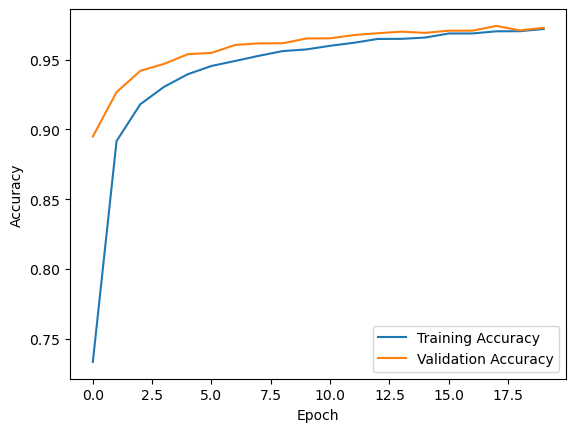

In [15]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_accu, label='Training Accuracy')
plt.plot(val_accu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

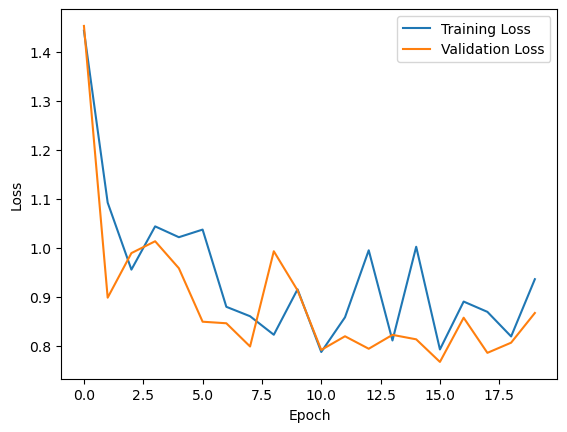

In [17]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# save model
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimiser.state_dict()}

torch.save(checkpoint, '20edeit.pth')

In [18]:
test_acc = 0
model.eval()
with torch.no_grad():
    for xtest, ytest in test_loader:
        xtest = xtest.to(device)
        test_prob = model(xtest)
        test_prob = test_prob.cpu()

        test_pred = torch.max(test_prob,1).indices
        test_acc += int(torch.sum(test_pred == ytest))

    ep_test_acc = test_acc / LEN_TEST2
print("test dataset accuracy: {}".format(ep_test_acc))

test dataset accuracy: 0.9688140223082177


In [10]:
#loading the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [11]:
model = load_checkpoint('../input/5edeit/5edeit.pth')
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [18]:
# Image Samples
sample_1 = '../input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG'
sample_2 = '../input/new-plant-diseases-dataset/test/test/CornCommonRust1.JPG'
sample_3 = '../input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight4.JPG'
sample_4 = '../input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus2.JPG'

sample_list = [sample_1,sample_2,sample_3,sample_4]

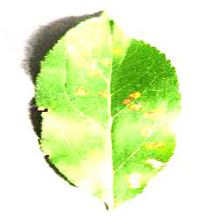

Apple___Cedar_apple_rust


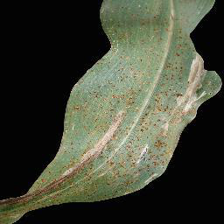

Corn_(maize)___Common_rust_


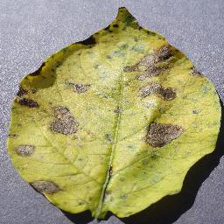

Potato___Early_blight


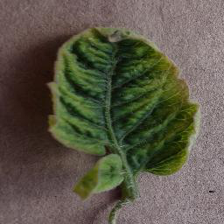

Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [19]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    kv = dataset.class_to_idx
    li = [k for k,v in kv.items() if v == pred]
    print(*li)